In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import tensorflow as tf

from agents.networks import ParallelMultilayerPerceptron, CountTensor
from environments.binomials import BinomialBuchbergerEnv, LeadMonomialWrapper

# Environment

In [2]:
variables = sp.symbols('x y z')
domain = sp.FF(32003)
order = 'grevlex'
degree = 7
size = 5
x, y, z = variables

env = LeadMonomialWrapper(BinomialBuchbergerEnv(degree, size, len(variables)))
env_full = LeadMonomialWrapper(BinomialBuchbergerEnv(degree, size, len(variables)), k=2)

# Agents

In [3]:
def discount_rewards(rewards, gamma):
    """Discount the array of rewards by gamma in-place."""
    cumulative_reward = 0
    for i in reversed(range(len(rewards))):
        cumulative_reward = rewards[i] + gamma * cumulative_reward
        rewards[i] = cumulative_reward
    return rewards


class TrajectoryBuffer:
    """A buffer for storing and computing with trajectories."""

    def __init__(self, capacity, gamma, lam):
        self.capacity = capacity
        self.gamma = gamma
        self.lam = lam
        self.states = np.empty(shape=capacity, dtype=np.object)
        self.actions = np.empty(shape=capacity, dtype=np.int16)
        self.rewards = np.empty(shape=capacity, dtype=np.float32)
        self.values = np.empty(shape=capacity, dtype=np.float32)       
        self.start = 0
        self.end = 0

    def store(self, state, action, reward, value):
        """Store the information from one state."""
        if self.end == self.capacity:
            return
        self.states[self.end] = state
        self.actions[self.end] = action
        self.rewards[self.end] = reward
        self.values[self.end] = value
        self.end += 1

    def finish(self):
        """Finish a trajectory and compute discounted rewards and advantages."""
        values = np.append(self.values[self.start:self.end], 0)
        rewards = self.rewards[self.start:self.end]

        # values are now GAE values
        delta = rewards + self.gamma * values[1:] - values[:-1]
        discount_rewards(delta, self.gamma * self.lam)
        self.values[self.start:self.end] = delta

        # rewards are now discounted rewards
        discount_rewards(self.rewards[self.start:self.end], self.gamma)

        self.start = self.end
    
    def get(self):
        """Return all the finished trajectories with advantages normalized."""
        final = self.start
        self.start, self.end = 0, 0
        m = np.mean(self.values[:final])
        s = np.std(self.values[:final])
        self.values[:final] -= m
        self.values[:final] /= s
        return self.states[:final], self.actions[:final], self.rewards[:final], self.values[:final]


class PGAgent:
    """A policy gradient agent."""

    def __init__(self,
                 policy_network, value_network,
                 policy_learning_rate=0.00025, value_learning_rate=0.001,
                 gamma=0.99, lam=0.95,
                 value_fits_per_epoch=10,
                 capacity=100000):
        self.policyModel = self._buildPolicyModel(policy_network, policy_learning_rate)
        self.valueModel = self._buildValueModel(value_network, value_learning_rate)
        self.gamma = gamma
        self.lam = lam
        self.value_fits_per_epoch = value_fits_per_epoch
        self.buf = TrajectoryBuffer(capacity, gamma, lam)

    def act(self, state):
        """Choose an action for the given state."""
        probs = self.policyModel.predict(np.expand_dims(state, axis=0))[0]
        return np.random.choice(len(probs), p=probs)

    def train(self, env, episodes):
        """Train the agent using policy gradients."""
        reward_out = np.zeros(episodes)

        # generate rollouts and store in buffer
        for i in range(episodes):
            state = env.reset()
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                value = -1 * self.valueModel.predict(np.expand_dims(state, axis=0))  # TODO: move -1 to net
                self.buf.store(state, action, reward, value)
                reward_out[i] += reward
                state = next_state
            self.buf.finish()

        states, actions, rewards, advantages = self.buf.get()
        
        # find indices corresponding to each size
        batches = {}
        for i in range(len(states)):
            size = states[i].shape[0]
            batches.setdefault(size, []).append(i)

        # fit to advantages to perform policy update
        for size in batches:
            if size == 1:
                continue
            s = np.stack(states[batches[size]])
            adv = np.zeros((len(s), size))
            adv[np.arange(len(s)), actions[batches[size]]] = advantages[batches[size]]
            self.policyModel.fit(s, adv, verbose=0)
            
        # fit to discounted rewards to perform value update
        for _ in range(self.value_fits_per_epoch):
            for size in batches:
                s = np.stack(states[batches[size]])
                r = np.expand_dims(rewards[batches[size]], axis=1)
                self.valueModel.fit(s, r, verbose=0)

        return reward_out

    def loadPolicyModel(self, filename):
        self.policyModel.load_weights(filename)

    def savePolicyModel(self, filename):
        self.policyModel.save_weights(filename)

    def loadValueModel(self, filename):
        self.valueModel.load_weights(filename)

    def saveValueModel(self, filename):
        self.valueModel.save_weights(filename)

    def _buildPolicyModel(self, network, learning_rate):
        model = tf.keras.models.clone_model(network)
        loss = 'categorical_crossentropy'
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        model.compile(loss=loss, optimizer=optimizer)
        return model

    def _buildValueModel(self, network, learning_rate):
        model = tf.keras.models.clone_model(network)
        loss = 'mse'
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        model.compile(loss=loss, optimizer=optimizer)
        return model

# Testing

In [4]:
def test(agent, env, episodes):
    rewards = np.zeros(episodes)
    for i in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.act(state)
            state, reward, done, _ = env.step(action)
            rewards[i] += reward
    return rewards

In [5]:
network1 = ParallelMultilayerPerceptron(6, [48])
network2 = CountTensor((None, 1, 6), 1)
agent = PGAgent(network1, network2, policy_learning_rate=0.00001)

In [6]:
epochs = 50
rewards = []

for i in range(epochs):
    r = np.mean(agent.train(env, 1000))
    rewards.append(r)
    print("\rEpoch {}/{} - avg_reward: {}".format(i+1, epochs, r), end="")

Epoch 50/50 - avg_reward: -169.518

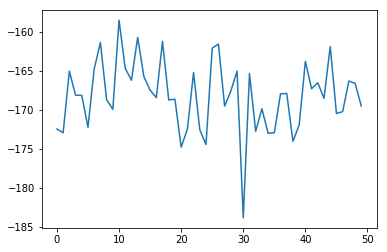

In [7]:
plt.plot(rewards)